# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

import pandas
import numpy
from matplotlib import pylab
import seaborn

import ipywidgets as ipyw

import IPython
from IPython.display import display

In [3]:
import itertools
import toolz.dicttoolz
from toolz.dicttoolz import merge

In [4]:
!git show --oneline -s HEAD

f2366bf Add per-round homogenous leak model to protease_sequencing_model.


In [5]:
import jug
jug.init("replicate_analysis.py")
import replicate_analysis

In [6]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = jug.value(model_results)

In [7]:
summary_frames = { d : {} for d in replicate_pairs }

for d, p in itertools.product(replicate_pairs, parameter_sets):
    sframes = []
    for mn in replicate_pairs[d]:
        counts = data.counts[mn]
        params = model_results[(mn, p)]["params"]
        preds = model_results[(mn, p)]["predictions"]
        
        sf = counts[["name"]].copy()
        sf["ec50"] = params["sel_ec50"]
        
        for g in preds:
            obs_dist = counts["counts%s" % g] / counts["counts%s" % g].sum()
            pred_dist = preds[g]["selection_dist"] / preds[g]["selection_dist"].sum()
            
            lobs_dist = numpy.log(obs_dist).clip(-9, None)
            lpred_dist = numpy.log(pred_dist).clip(-9, None)
            sf["l_dist_delta_%s" % g] = lobs_dist - lpred_dist
            sf["l_dist_delta_%s" % g][obs_dist == 0] = numpy.nan
            
        sframes.append(sf)
    
    summary_frames[d][p] = pandas.merge(*sframes, how="inner", on="name")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
grocklin_fit_results = pandas.read_pickle("161115_grocklin_fit_results.pickle")

grockin_fit_frames = {
    d : pandas.merge(
        *[grocklin_fit_results[n][["name", "ec50"]] for n in p],
        how="inner", on="name"
    )
    for d, p in replicate_pairs.items()
}

In [9]:
import scipy.stats
from scipy.stats import pearsonr
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [10]:
model_param_evaluations = {
    "pearsonr" : lambda x1, x2: scipy.stats.pearsonr(x1, x2)[0],
    "neg_mse" : lambda x1, x2: -mean_squared_error(x1, x2),
    "neg_outlier_mse" : lambda x1, x2: (
        -numpy.mean(numpy.clip(numpy.abs(x1 - x2) - 1, 0, None) ** 2))
}

# Evaluation Overview

Adding evaluation via existing `model_param_evaluations` metrics, which measure concordance of replicate experiements.

Adding evaluation of model quality via sort-of-hacky mean-square-log-delta between observed and predicted population distributions. `ms_log_d` is a per-sort-round evaluation and `sum_ms_log_d` is a sum of per-sort-round evaluations.

In [11]:
eval_records = [
    merge(
        {
            "param_set" : param_set,
        },
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(param_set),
        dict(dataset=dataset),
        { 
            "fit_" + v : model_results[(dataset, param_set)]["params"].get(v, None)
            for v in ("min_selection_mass", "min_selection_rate")
        },
        { "sel_k" : float(model_results[(dataset, param_set)]["params"]["sel_k"]) },
        {
            "ms_log_d_%s" % g : numpy.nanmean(numpy.square(sf["l_dist_delta_%s_x" % g]))
            for g in range(1, 7)
        },
    )
    for dataset in summary_frames
    for param_set, sf in summary_frames[dataset].items()
]

eval_records = pandas.DataFrame.from_records(eval_records)

eval_records["neg_sum_ms_log_d"] = -eval_records[["ms_log_d_%s" % i for i in range(1, 7)]].sum(axis=1)

In [12]:
grockin_eval_records = pandas.DataFrame.from_records([
    merge(
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(dataset=dataset),
    )
    for dataset, sf in grockin_fit_frames.items()
])

grockin_eval_records.sort_values("dataset")

,dataset,neg_mse,neg_outlier_mse,pearsonr
1,rd2_chymo,-1.761397,-0.686568,0.583877
2,rd2_tryp,-1.704013,-0.570927,0.453168
3,rd3_chymo,-0.347277,-0.068745,0.890660
0,rd3_tryp,-0.368697,-0.054830,0.892365


In [13]:
measures = ["neg_outlier_mse", "pearsonr", "neg_sum_ms_log_d"]

for param in replicate_analysis.param_space:
    rpt = eval_records.groupby(param)[measures].max()
    delta = (rpt - rpt.min()).rename(columns=lambda c: "delta_" + c)
    
    display(pandas.concat([rpt, delta], axis=1))

,neg_outlier_mse,pearsonr,neg_sum_ms_log_d,delta_neg_outlier_mse,delta_pearsonr,delta_neg_sum_ms_log_d
min_selection_mass,,,,,,
False,-0.087708,0.869470,-0.352488,0.436748,0.518749,5.009006
1e-06,-0.051879,0.894285,-0.441191,0.472576,0.543564,4.920303
1e-05,-0.116637,0.865179,-1.156724,0.407819,0.514458,4.204770
0.0001,-0.416315,0.682055,-3.809500,0.108141,0.331334,1.551994
0.001,-0.524456,0.352110,-5.240890,0.000000,0.001389,0.120604
0.01,-0.187284,0.350721,-5.361494,0.337172,0.000000,0.000000
global,-0.059270,0.881240,-0.385347,0.465186,0.530519,4.976148
per_selection,-0.087922,0.862611,-0.387706,0.436534,0.511890,4.973788


,neg_outlier_mse,pearsonr,neg_sum_ms_log_d,delta_neg_outlier_mse,delta_pearsonr,delta_neg_sum_ms_log_d
response_fn,,,,,,
NormalSpaceLogisticResponse,-0.051879,0.894285,-0.352488,0.0,0.0,0.0


In [14]:
(
eval_records
.groupby(["dataset"])
.apply(lambda df: df.sort_values("neg_outlier_mse", ascending=False).head(1))
.sort_values("dataset")
)

,,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
dataset,,,,,,,,,,,,,,,,,,
rd2_chymo,8,rd2_chymo,None,None,0.01,0.452074,0.604522,1.089586,1.838434,2.299844,2.629360,-1.619921,-0.588128,"((min_selection_mass, 0.01), (response_fn, Nor...",0.174027,NormalSpaceLogisticResponse,6.399058,-8.913820
rd2_tryp,16,rd2_tryp,None,None,0.01,0.347727,0.488028,1.025708,1.826356,3.137123,4.216517,-1.770781,-0.502577,"((min_selection_mass, 0.01), (response_fn, Nor...",0.103914,NormalSpaceLogisticResponse,6.500007,-11.041459
rd3_chymo,25,rd3_chymo,4.22480260166e-07,None,global,0.021843,0.034793,0.067977,0.571452,0.208576,2.182227,-0.484420,-0.088061,"((min_selection_mass, global), (response_fn, N...",0.867536,NormalSpaceLogisticResponse,1.551051,-3.086868
rd3_tryp,2,rd3_tryp,None,None,1e-06,0.012210,0.014099,0.048937,0.076414,0.061961,0.227570,-0.377424,-0.051879,"((min_selection_mass, 1e-06), (response_fn, No...",0.894285,NormalSpaceLogisticResponse,6.498697,-0.441191


In [15]:
import IPython

for g, df in eval_records.groupby("dataset"):
    IPython.display.display(g)
    IPython.display.display(df.sort_values("neg_outlier_mse", ascending=False))


'rd2_chymo'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
8,rd2_chymo,None,None,0.01,0.452074,0.604522,1.089586,1.838434,2.299844,2.629360,-1.619921,-0.588128,"((min_selection_mass, 0.01), (response_fn, Nor...",0.174027,NormalSpaceLogisticResponse,6.399058,-8.913820
13,rd2_chymo,None,None,1e-05,0.092312,0.127781,0.064520,0.387984,0.435975,0.864605,-1.816710,-0.604733,"((min_selection_mass, 1e-05), (response_fn, No...",0.572433,NormalSpaceLogisticResponse,1.499908,-1.973178
14,rd2_chymo,None,None,0.0001,0.189493,0.311465,0.346486,1.276196,1.208437,1.900139,-1.714515,-0.627568,"((min_selection_mass, 0.0001), (response_fn, N...",0.569934,NormalSpaceLogisticResponse,6.499904,-5.232215
11,rd2_chymo,None,None,0.001,0.445143,0.597295,1.024412,1.805557,2.088329,2.499978,-1.763496,-0.675740,"((min_selection_mass, 0.001), (response_fn, No...",0.263474,NormalSpaceLogisticResponse,6.488648,-8.460714
10,rd2_chymo,None,None,1e-06,0.102354,0.132049,0.056609,0.290827,0.300477,0.576959,-1.802981,-0.698777,"((min_selection_mass, 1e-06), (response_fn, No...",0.562002,NormalSpaceLogisticResponse,1.499311,-1.459276
9,rd2_chymo,5.17967453686e-07,None,global,0.101757,0.132845,0.081055,0.447152,0.181500,0.358185,-2.260755,-0.826993,"((min_selection_mass, global), (response_fn, N...",0.592038,NormalSpaceLogisticResponse,0.528937,-1.302492
15,rd2_chymo,"[2.35796606479e-10, 1.48703456267e-07, 5.59880...",None,per_selection,0.102576,0.134030,0.077476,0.432549,0.232054,0.579235,-2.761255,-1.193327,"((min_selection_mass, per_selection), (respons...",0.529516,NormalSpaceLogisticResponse,0.687049,-1.557922
12,rd2_chymo,None,None,False,0.105071,0.141078,0.095675,0.548519,0.169674,0.322692,-2.971992,-1.335348,"((response_fn, NormalSpaceLogisticResponse), (...",0.522430,NormalSpaceLogisticResponse,0.451282,-1.382709


'rd2_tryp'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
16,rd2_tryp,None,None,0.01,0.347727,0.488028,1.025708,1.826356,3.137123,4.216517,-1.770781,-0.502577,"((min_selection_mass, 0.01), (response_fn, Nor...",0.103914,NormalSpaceLogisticResponse,6.500007,-11.041459
17,rd2_tryp,8.91170076104e-07,None,global,0.034004,0.084006,0.068950,0.096211,0.041273,2.981740,-1.630559,-0.507848,"((min_selection_mass, global), (response_fn, N...",0.442168,NormalSpaceLogisticResponse,6.733935,-3.306185
23,rd2_tryp,"[5.33190235569e-11, 9.79602213618e-07, 3.67844...",None,per_selection,0.034624,0.085514,0.069562,0.095584,0.032856,3.474304,-1.704272,-0.559631,"((min_selection_mass, per_selection), (respons...",0.434725,NormalSpaceLogisticResponse,8.995323,-3.792444
18,rd2_tryp,None,None,1e-06,0.033737,0.082884,0.068553,0.095983,0.039813,3.017105,-1.828946,-0.585954,"((min_selection_mass, 1e-06), (response_fn, No...",0.407393,NormalSpaceLogisticResponse,6.500002,-3.338075
19,rd2_tryp,None,None,0.001,0.343488,0.484009,0.986079,1.766125,2.617551,4.216517,-2.310133,-0.907213,"((min_selection_mass, 0.001), (response_fn, No...",0.219639,NormalSpaceLogisticResponse,6.498095,-10.413769
20,rd2_tryp,None,None,False,0.042059,0.116489,0.076177,0.136452,0.049319,2.679714,-2.285048,-0.913417,"((response_fn, NormalSpaceLogisticResponse), (...",0.379741,NormalSpaceLogisticResponse,3.811155,-3.100210
21,rd2_tryp,None,None,1e-05,0.030915,0.069537,0.070281,0.156835,0.137438,3.603567,-2.631258,-1.122713,"((min_selection_mass, 1e-05), (response_fn, No...",0.381972,NormalSpaceLogisticResponse,6.500022,-4.068572
22,rd2_tryp,None,None,0.0001,0.118625,0.232557,0.388116,1.001569,1.063743,4.075070,-2.719714,-1.193937,"((min_selection_mass, 0.0001), (response_fn, N...",0.353294,NormalSpaceLogisticResponse,6.500084,-6.879680


'rd3_chymo'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
25,rd3_chymo,4.22480260166e-07,None,global,0.021843,0.034793,0.067977,0.571452,0.208576,2.182227,-0.484420,-0.088061,"((min_selection_mass, global), (response_fn, N...",0.867536,NormalSpaceLogisticResponse,1.551051,-3.086868
26,rd3_chymo,None,None,1e-06,0.016850,0.023660,0.036717,0.199552,0.264901,2.809973,-0.624512,-0.092957,"((min_selection_mass, 1e-06), (response_fn, No...",0.875162,NormalSpaceLogisticResponse,6.500032,-3.351653
31,rd3_chymo,"[8.79998286591e-12, 4.34604018324e-11, 4.04364...",None,per_selection,0.021984,0.035299,0.066319,0.555520,0.208998,2.933937,-0.437982,-0.096816,"((min_selection_mass, per_selection), (respons...",0.848005,NormalSpaceLogisticResponse,1.667317,-3.822057
28,rd3_chymo,None,None,False,0.021704,0.034709,0.066881,0.566128,0.205586,2.020707,-0.708896,-0.113462,"((response_fn, NormalSpaceLogisticResponse), (...",0.869470,NormalSpaceLogisticResponse,1.575144,-2.915715
29,rd3_chymo,None,None,1e-05,0.016043,0.021703,0.042694,0.450033,0.707654,3.020731,-0.612740,-0.154441,"((min_selection_mass, 1e-05), (response_fn, No...",0.833650,NormalSpaceLogisticResponse,6.500041,-4.258857
30,rd3_chymo,None,None,0.0001,0.046961,0.114899,0.322923,1.387324,2.058113,3.348687,-1.295911,-0.416315,"((min_selection_mass, 0.0001), (response_fn, N...",0.682055,NormalSpaceLogisticResponse,6.500042,-7.278906
24,rd3_chymo,None,None,0.01,0.104838,0.181776,0.571222,1.495883,2.996808,3.611503,-1.352601,-0.490874,"((min_selection_mass, 0.01), (response_fn, Nor...",0.068036,NormalSpaceLogisticResponse,6.497570,-8.962031
27,rd3_chymo,None,None,0.001,0.104838,0.181776,0.570249,1.495880,2.853106,3.545210,-1.725744,-0.524456,"((min_selection_mass, 0.001), (response_fn, No...",0.216175,NormalSpaceLogisticResponse,6.497426,-8.751060


'rd3_tryp'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
2,rd3_tryp,None,None,1e-06,0.012210,0.014099,0.048937,0.076414,0.061961,0.227570,-0.377424,-0.051879,"((min_selection_mass, 1e-06), (response_fn, No...",0.894285,NormalSpaceLogisticResponse,6.498697,-0.441191
1,rd3_tryp,5.48829355936e-07,None,global,0.012264,0.013844,0.048913,0.072025,0.058206,0.180095,-0.412727,-0.059270,"((min_selection_mass, global), (response_fn, N...",0.881240,NormalSpaceLogisticResponse,9.000000,-0.385347
4,rd3_tryp,None,None,False,0.014498,0.016121,0.062463,0.084941,0.052167,0.122299,-0.467924,-0.087708,"((response_fn, NormalSpaceLogisticResponse), (...",0.847094,NormalSpaceLogisticResponse,8.999957,-0.352488
7,rd3_tryp,"[4.9796559952e-12, 2.90233006519e-07, 4.199475...",None,per_selection,0.014505,0.016062,0.062119,0.084411,0.052762,0.157847,-0.488186,-0.087922,"((min_selection_mass, per_selection), (respons...",0.862611,NormalSpaceLogisticResponse,8.999959,-0.387706
5,rd3_tryp,None,None,1e-05,0.009966,0.012449,0.050109,0.088168,0.275391,0.720642,-0.565298,-0.116637,"((min_selection_mass, 1e-05), (response_fn, No...",0.865179,NormalSpaceLogisticResponse,6.500049,-1.156724
0,rd3_tryp,None,None,0.01,0.073786,0.104987,0.324729,1.164022,1.469541,2.224428,-0.955958,-0.187284,"((min_selection_mass, 0.01), (response_fn, Nor...",0.350721,NormalSpaceLogisticResponse,6.499489,-5.361494
6,rd3_tryp,None,None,0.0001,0.025615,0.049662,0.251654,0.688616,1.225258,1.568695,-1.584343,-0.566071,"((min_selection_mass, 0.0001), (response_fn, N...",0.656769,NormalSpaceLogisticResponse,6.500105,-3.809500
3,rd3_tryp,None,None,0.001,0.073786,0.104987,0.324729,1.161347,1.468434,2.107606,-2.279847,-0.869030,"((min_selection_mass, 0.001), (response_fn, No...",0.352110,NormalSpaceLogisticResponse,6.500052,-5.240890


# General Conclusions

Pretty hard to tell from these spray-tables, but it appears that the adaptive leak model is allowing convergance to a very high sel-k and causing degredation of late-sort-round fits. This improves the model prediction MSE and outlier mse measure, but "compressesss" models at ec50 > 4 into lower parts of the range.

In [16]:
def plot_eval_pair(ax, idx):
    dataset = eval_records.ix[idx]["dataset"]
    params = eval_records.ix[idx]["param_set"]
    fit_params = model_results[(dataset, params)]["params"]

    sf = summary_frames[dataset][params]

    params = dict(params)
    title = ["%s (%i)" % (dataset, idx)]
    for k in sorted(params):
        if k in fit_params:
            p = numpy.atleast_1d(fit_params[k])
            title.append("%s: %s (%s)" % (k, params[k], ",".join("%.1e" % f for f in p)))
        else:
            title.append("%s: %s" % (k, params[k]))
    title.append("sel_k: %.2f" % fit_params["sel_k"])

    ax.set_title("\n".join(title))
    
    pairplot_ec50(ax, sf)
    
def pairplot_ec50(ax, sf):
    sf.plot.hexbin("ec50_x", "ec50_y", mincnt=1, gridsize=50, ax=ax)
    data, binx, biny = numpy.histogram2d(
        sf["ec50_x"].values, sf["ec50_y"].values, bins=[-2, 0, 2, 4, 8], normed=True)
    for x in binx[1:-1]:
        ax.axvline(x, alpha=.1)
    for y in biny[1:-1]:
        ax.axhline(y, alpha=.1)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(
                binx[x] + 0.5,
                biny[y] + 0.5,
                '%.1e' % data[y, x],
                fontsize = "small",
                verticalalignment='bottom',
        
            )


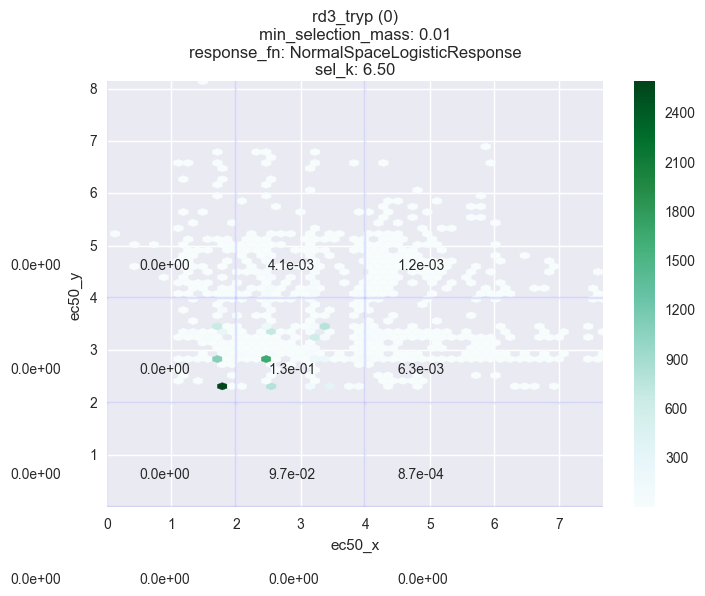

In [17]:
@ipyw.interact
def plot_single(idx=ipyw.IntSlider(min=min(eval_records.index.values), max=max(eval_records.index.values))):
    plot_eval_pair(pylab.gca(), idx)

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
0,rd3_tryp,None,None,0.01,0.073786,0.104987,0.324729,1.164022,1.469541,2.224428,-0.955958,-0.187284,"((min_selection_mass, 0.01), (response_fn, Nor...",0.350721,NormalSpaceLogisticResponse,6.499489,-5.361494
2,rd3_tryp,None,None,1e-06,0.012210,0.014099,0.048937,0.076414,0.061961,0.227570,-0.377424,-0.051879,"((min_selection_mass, 1e-06), (response_fn, No...",0.894285,NormalSpaceLogisticResponse,6.498697,-0.441191


,dataset,neg_mse,neg_outlier_mse,pearsonr
0,rd3_tryp,-0.368697,-0.05483,0.892365


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
8,rd2_chymo,None,None,0.01,0.452074,0.604522,1.089586,1.838434,2.299844,2.629360,-1.619921,-0.588128,"((min_selection_mass, 0.01), (response_fn, Nor...",0.174027,NormalSpaceLogisticResponse,6.399058,-8.913820
9,rd2_chymo,5.17967453686e-07,None,global,0.101757,0.132845,0.081055,0.447152,0.181500,0.358185,-2.260755,-0.826993,"((min_selection_mass, global), (response_fn, N...",0.592038,NormalSpaceLogisticResponse,0.528937,-1.302492


,dataset,neg_mse,neg_outlier_mse,pearsonr
1,rd2_chymo,-1.761397,-0.686568,0.583877


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
16,rd2_tryp,None,None,0.01,0.347727,0.488028,1.025708,1.826356,3.137123,4.216517,-1.770781,-0.502577,"((min_selection_mass, 0.01), (response_fn, Nor...",0.103914,NormalSpaceLogisticResponse,6.500007,-11.041459
17,rd2_tryp,8.91170076104e-07,None,global,0.034004,0.084006,0.068950,0.096211,0.041273,2.981740,-1.630559,-0.507848,"((min_selection_mass, global), (response_fn, N...",0.442168,NormalSpaceLogisticResponse,6.733935,-3.306185


,dataset,neg_mse,neg_outlier_mse,pearsonr
2,rd2_tryp,-1.704013,-0.570927,0.453168


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
24,rd3_chymo,None,None,0.01,0.104838,0.181776,0.571222,1.495883,2.996808,3.611503,-1.352601,-0.490874,"((min_selection_mass, 0.01), (response_fn, Nor...",0.068036,NormalSpaceLogisticResponse,6.497570,-8.962031
26,rd3_chymo,None,None,1e-06,0.016850,0.023660,0.036717,0.199552,0.264901,2.809973,-0.624512,-0.092957,"((min_selection_mass, 1e-06), (response_fn, No...",0.875162,NormalSpaceLogisticResponse,6.500032,-3.351653


,dataset,neg_mse,neg_outlier_mse,pearsonr
3,rd3_chymo,-0.347277,-0.068745,0.89066


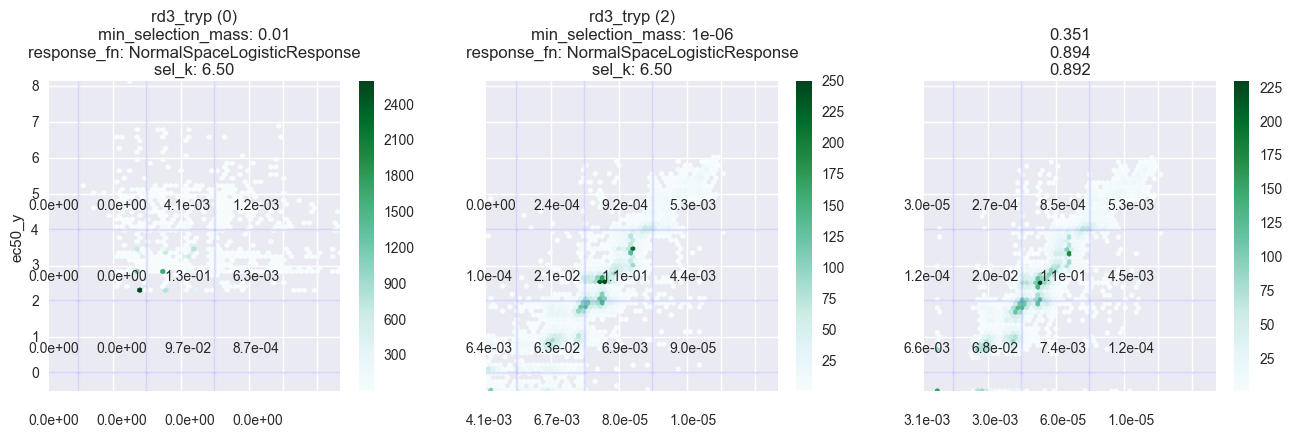

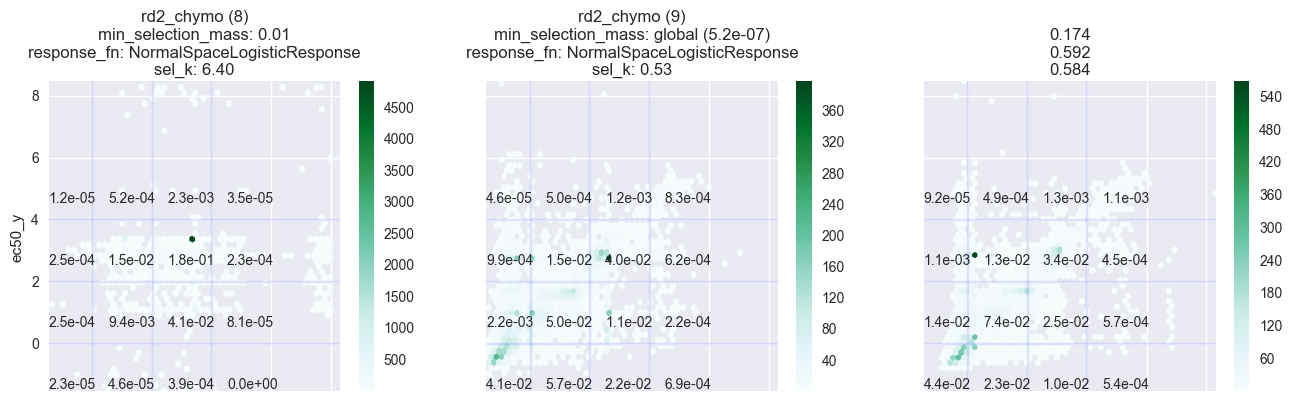

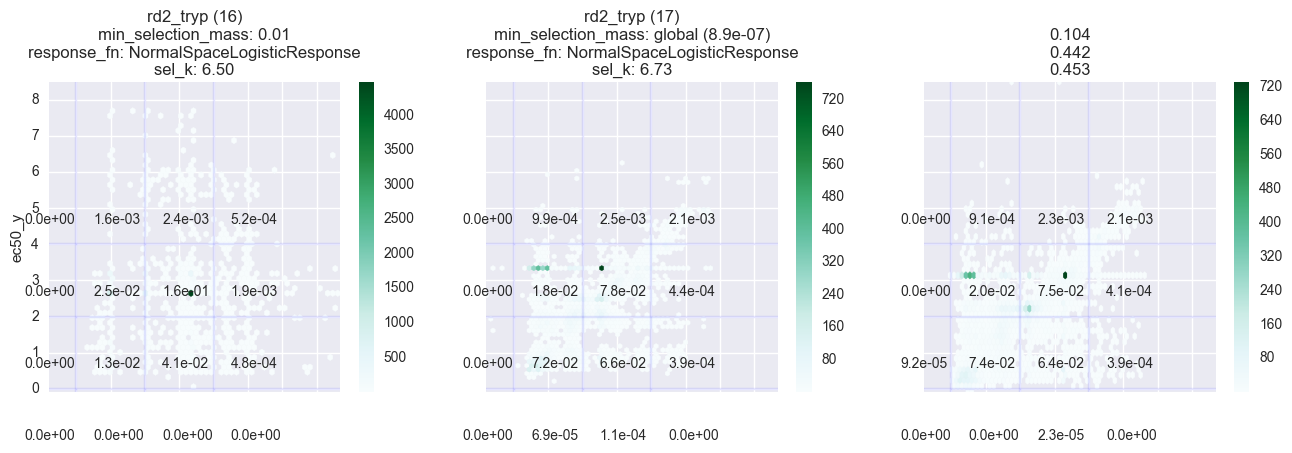

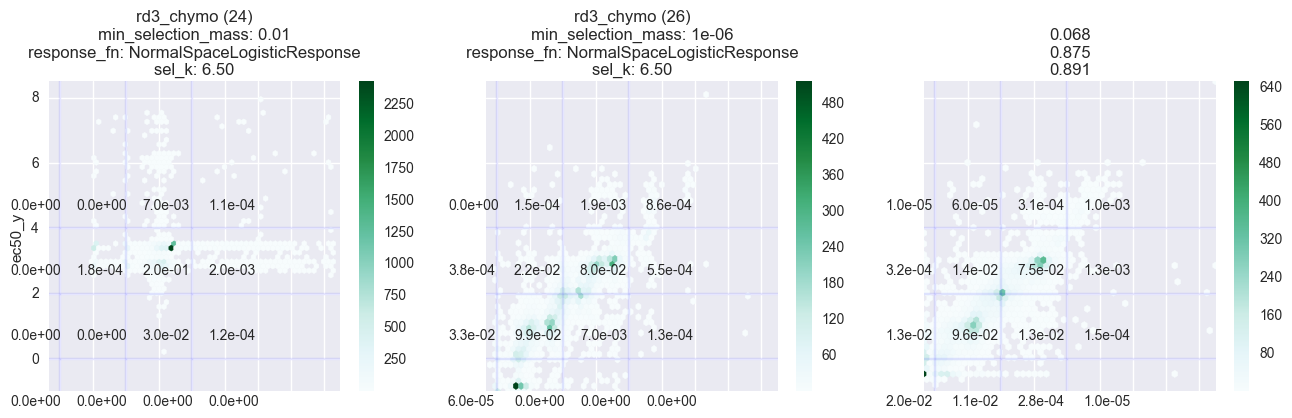

In [19]:
@ipyw.interact
def display_records(metric = list(model_param_evaluations) + ["sum_ms_log_d"]):
    
    for dataset in list(pandas.unique(eval_records["dataset"])):


        ss = eval_records[eval_records["dataset"] == dataset].sort_values(metric)
        b_i = ss.index[0]
        w_i = ss.index[-1]

        display(ss.iloc[[0, -1]])
        display(grockin_eval_records[grockin_eval_records["dataset"] == dataset])

        f, (a1, a2, a3) = pylab.subplots(ncols=3, sharex=True, sharey=True, figsize=(16, 4))
        plot_eval_pair(a1, b_i)
        plot_eval_pair(a2, w_i)
        
        pairplot_ec50(a3, grockin_fit_frames[dataset])
        
        a3.set_title("%.3f\n%.3f\n%.3f" % (
                ss.iloc[0][metric],
                ss.iloc[-1][metric],
                grockin_eval_records.query("dataset == '%s'" % dataset).iloc[0][metric]
        ))